In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Metadata

In [2]:
## Load metadata.
metadata = read_csv(os.path.join('data', 'metadata.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
metadata = metadata[metadata.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)

#### 1.1 Gender composition

In [3]:
## Describe gender composition.
metadata.groupby('gender').age.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,147.0,33.0,13.1,18.0,23.0,29.0,41.0,70.0
Male,138.0,38.0,13.2,18.0,28.0,36.0,46.8,76.0
Other,13.0,27.5,6.5,19.0,22.0,26.0,30.0,39.0
Rather not say,2.0,25.5,3.5,23.0,24.2,25.5,26.8,28.0


In [4]:
metadata.age.describe()

count    300.000000
mean      34.996667
std       13.202943
min       18.000000
25%       24.000000
50%       32.000000
75%       43.000000
max       76.000000
Name: age, dtype: float64

#### 1.2 Race / ethnicity

In [5]:
## Describe race endorsement.
metadata.race.value_counts()

['White']                                                 226
['Asian']                                                  27
['Black or African American']                              26
['Rather not say']                                          8
['Asian', 'White']                                          7
['Asian', 'Black or African American']                      2
['Native Hawaiian or other Pacific Islander', 'White']      1
['American Indian/Alaska Native']                           1
['American Indian/Alaska Native', 'White']                  1
['Black or African American', 'White']                      1
Name: race, dtype: int64

#### 1.3 Education

In [6]:
## Describe education endorsement.
metadata.education.value_counts()

Bachelor degree            121
Some college                74
Master degree or higher     45
High school                 31
Associate degree            26
Less than high school        2
Rather not say               1
Name: education, dtype: int64

#### 1.4 Timing

In [7]:
## Load metadata.
timing = read_csv(os.path.join('data', 'timing.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
timing = timing[timing.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)

## Describe task timing.
timing.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
total,300.0,645.7,273.8,272.8,496.1,593.8,734.6,2402.0
surveys_total,300.0,204.0,150.7,74.4,136.4,166.4,216.6,1765.5
mars_total,300.0,270.7,152.7,117.0,198.6,247.8,301.7,2087.3
mars_task,300.0,174.2,54.0,52.6,133.7,173.7,212.5,297.1
mars_interactions,300.0,1.8,2.2,1.0,1.0,1.0,2.0,22.0
rpm_total,300.0,171.0,123.2,43.4,126.8,158.9,186.8,1747.6
rpm_task,300.0,124.6,40.1,18.6,97.9,127.2,151.0,243.1
rpm_interactions,300.0,1.6,1.6,0.0,1.0,1.0,1.0,13.0


## Section 2: Progressive Matrices

In [8]:
## Load data.
mars = read_csv(os.path.join('data', 'mars.csv'))
rpm  = read_csv(os.path.join('data', 'rpm.csv'))

## Apply rejections.
mars = mars[mars.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)
rpm  = rpm[rpm.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)

## Handle missing responses.
mars = mars.fillna(0)
rpm  = rpm.fillna(0)

## Define sum scores.
scores = DataFrame(dict(
    subject = mars.subject.unique(),
    short_form = mars.groupby('subject').short_form.mean().astype(int).values,
    mars = mars.groupby('subject').accuracy.sum().astype(int).values,
    rpm = rpm.groupby('subject').accuracy.sum().astype(int).values,
))

#### 2.1 MARS Scores

In [9]:
## Describe score distributions.
scores.groupby('short_form').mars.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
short_form,,,,,,,,
1,103.0,7.9,2.4,2.0,7.0,8.0,10.0,12.0
2,98.0,8.2,2.6,1.0,7.0,9.0,10.0,12.0
3,99.0,7.9,2.7,1.0,6.0,8.0,10.0,12.0


#### 2.2 RPM Scores

In [10]:
## Describe score distributions.
scores.rpm.describe().round(1)

count    300.0
mean       4.5
std        2.0
min        0.0
25%        3.0
50%        5.0
75%        6.0
max        9.0
Name: rpm, dtype: float64

In [11]:
scores.mars.describe()

count    300.000000
mean       8.003333
std        2.534707
min        1.000000
25%        6.000000
50%        8.000000
75%       10.000000
max       12.000000
Name: mars, dtype: float64

In [12]:
from scipy.stats import f_oneway

a = scores.query('short_form == 1').mars.values
b = scores.query('short_form == 2').mars.values
c = scores.query('short_form == 3').mars.values

f_oneway(a,b,c)

F_onewayResult(statistic=0.25269128003541735, pvalue=0.7768744452906258)

In [13]:
from scipy.stats import ttest_rel

ttest_rel(scores.mars / 12, scores.rpm / 9)

Ttest_relResult(statistic=13.02783445280114, pvalue=4.925829669190968e-31)

#### 2.3 Correlation

In [14]:
from arviz import hdi

samples = read_csv('stan_results/3pl.tsv.gz', index_col=0, sep='\t', compression='gzip')

for i in [1,2,3]:

    ## Extract samples.
    arr = samples[f'rho[{i}]'].values
    
    ## Compute mean.
    mu = np.mean(arr)
    
    ## Compute HDI.
    lb, ub = hdi(arr, hdi_prob=0.95)
    
    print('rho[%s]:\t%0.3f\t[%0.3f, %0.3f]' %(i,mu,lb,ub))

rho[1]:	-0.123	[-0.253, 0.013]
rho[2]:	-0.025	[-0.160, 0.108]
rho[3]:	0.527	[0.457, 0.577]


## Section 3: Figures

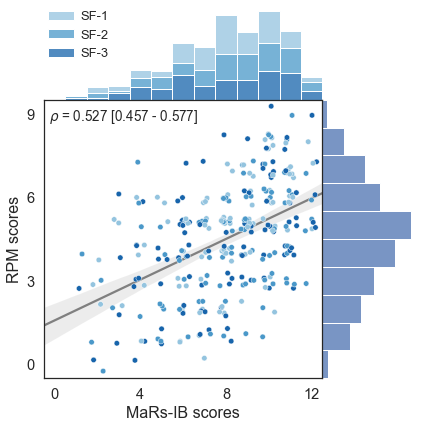

In [15]:
import matplotlib.gridspec as gridspec
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(6,6))

## Initialize panels.
spec = fig.add_gridspec(4,4, left=0.12, right=0.98, top=0.98, bottom=0.12, wspace=0, hspace=0)

## Define palette.
palette = sns.color_palette('Blues', n_colors=4).as_hex()[1:]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel A: MaRs-IB scores.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize axis.
ax = plt.subplot(spec[0,:3])

## Plot MARS scores.
sns.histplot(x='mars', hue='short_form', data=scores, bins=np.arange(14)-0.5, 
             multiple='stack', legend=True, palette=palette, ax=ax)
ax.set(xlim=(-0.5, 12.5), xticks=np.arange(0,13,4), xticklabels=[], yticks=[], ylabel='')

## Update legend.
legend = ax.get_legend()
handles = legend.legendHandles
ax.legend(handles, ['SF-1','SF-2','SF-3'], loc=2, frameon=False, fontsize=13,
          handletextpad=0.5, borderpad=-0.2)

## Remove spines.
sns.despine(ax=ax, left=True, right=True, top=True, bottom=True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel B: RPM scores.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize axis.
ax = plt.subplot(spec[1:,-1])

## Plot RPM scores.
sns.histplot(y='rpm', data=scores, bins=np.arange(11)-0.5, ax=ax)
ax.set(ylim=(-0.5, 9.5), yticks=np.arange(0,10,3), yticklabels=[], xticks=[], xlabel='')

## Remove spines.
sns.despine(ax=ax, left=True, right=True, top=True, bottom=True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel C: Scatterplot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize axis.
ax = plt.subplot(spec[1:,:3])

# ## Add jitter.
scores['mars_j'] = scores['mars'] + np.random.uniform(-0.3,0.3,len(scores))
scores['rpm_j'] = scores['rpm'] + np.random.uniform(-0.3,0.3,len(scores))

## Plot joint scores.
ax.set(xlim=(-0.5, 12.5), ylim=(-0.5, 9.5))
sns.regplot(x='mars', y='rpm', data=scores, color='grey', scatter=False, truncate=False, ax=ax)
sns.scatterplot(x='mars_j', y='rpm_j', hue='short_form', data=scores, palette=palette, s=30, zorder=10, ax=ax)
ax.set(xticks=np.arange(0,13,4), xlabel='MaRs-IB scores', yticks=np.arange(0,10,3), ylabel='RPM scores')
ax.legend_.set_visible(False)

## Add annotation.
ax.annotate(r'$\rho$ = 0.527 [0.457 - 0.577]', (0,0), (0.02,0.97), xycoords='axes fraction', 
            ha='left', va='top', fontsize=13.5)

plt.savefig(os.path.join('..', '05_Figures', 'fig03.png'), dpi=100)